In [1]:
!git clone https://github.com/millermuttu/TSAI-EVA5.git

Cloning into 'TSAI-EVA5'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 131 (delta 47), reused 70 (delta 17), pack-reused 0
Receiving objects: 100% (131/131), 558.82 KiB | 11.64 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
cd /content/TSAI-EVA5/modulerized_code

/content/TSAI-EVA5/modulerized_code


In [3]:
ls

dataset/  models/  train_test.py  utils/


In [18]:

# Importing torch packages for Neural Network building and our modulerized functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from torchsummary import summary
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from models.resnet import *
from utils.img_reg import *
from train_test import *
from dataset.load_dataset import load_dataset_fn

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset, trainloader, testset, testloader = load_dataset_fn('CIFAR10',transform_train,transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Image regulerization

In [7]:
mean,std = image_normalization_3(trainset)
mean,std

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

#dataset visulaization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer  deer  frog   cat


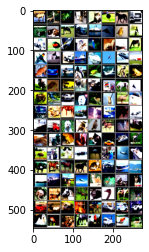

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.49139968     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [23]:
def run_models(model, device, epochs, reg, lambda1 = 0.0002, lambda2 = 0.0001):
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  misclassified_images = []
  model = model.to(device)
  if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
  optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


  for epoch in range(epochs):
      print("EPOCH:", epoch+1)
      train(model, device, trainloader, optimizer, epoch, reg, lambda1, lambda2, train_losses, train_acc)
      scheduler.step()
      if epoch !=100:
        test(model, device, testloader, test_losses, test_acc, misclassified_images)
      else:
        test(model, device, testloader, test_losses, test_acc, misclassified_images, misclassified=True)
  
  return test_losses, test_acc, misclassified_images

In [24]:
gbn_loss, gbn_acc, gbn_misclassified = run_models(ResNet18(), device, 20, "None")

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.6483, Accuracy: 3802/10000 (38.02%)

EPOCH: 2


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.3052, Accuracy: 5218/10000 (52.18%)

EPOCH: 3


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2152, Accuracy: 5858/10000 (58.58%)

EPOCH: 4


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9823, Accuracy: 6547/10000 (65.47%)

EPOCH: 5


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8729, Accuracy: 6890/10000 (68.90%)

EPOCH: 6


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8188, Accuracy: 7169/10000 (71.69%)

EPOCH: 7


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5094, Accuracy: 8207/10000 (82.07%)

EPOCH: 8


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4800, Accuracy: 8316/10000 (83.16%)

EPOCH: 9


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4565, Accuracy: 8429/10000 (84.29%)

EPOCH: 10


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4446, Accuracy: 8506/10000 (85.06%)

EPOCH: 11


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4495, Accuracy: 8487/10000 (84.87%)

EPOCH: 12


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4264, Accuracy: 8560/10000 (85.60%)

EPOCH: 13


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3872, Accuracy: 8683/10000 (86.83%)

EPOCH: 14


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3815, Accuracy: 8691/10000 (86.91%)

EPOCH: 15


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3835, Accuracy: 8702/10000 (87.02%)

EPOCH: 16


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3789, Accuracy: 8731/10000 (87.31%)

EPOCH: 17


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3773, Accuracy: 8745/10000 (87.45%)

EPOCH: 18


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3761, Accuracy: 8737/10000 (87.37%)

EPOCH: 19


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3746, Accuracy: 8754/10000 (87.54%)

EPOCH: 20


Loss=0.298 Batch_id=390 Accuracy=90.59: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]



Test set: Average loss: 0.3744, Accuracy: 8741/10000 (87.41%)

